# Data preparation and analysis (with_outliers)


## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import plotly.express as px
from matplotlib import pyplot
import time
import random
from IPython.display import Image
import plotly.express as px
import warnings
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from xgboost import plot_importance
import lightgbm as lgb
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
from sklearn.linear_model import LassoCV, LassoLarsIC, LassoLarsCV, LogisticRegression, ElasticNetCV
from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold, GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE, RFECV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer, roc_auc_score, classification_report
from collections import Counter
import matplotlib.pyplot as plt
import joblib
import pickle
import requests
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from utils import save_reconstructed_images, create_environment, create_json, save_datasets # save_pickle_object, load_pickle_object

## Useful functions

In [2]:
#Load lasso model
def get_best_alpha_lasso(path_lasso_model, lasso_model_graph, expression_data, labels, cv= 5, lars=False):    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')            
        if lars:
            start_time = time.time()
            lasso_model = LassoLarsCV(cv=cv).fit(expression_data, labels)
            fit_time = time.time() - start_time
            plt.semilogx(lasso_model.cv_alphas_, lasso_model.mse_path_, ":")
            plt.semilogx(
                lasso_model.cv_alphas_,
                lasso_model.mse_path_.mean(axis=-1),
                color="black",
                label="Average across the folds",
                linewidth=2,
            )
            plt.axvline(lasso_model.alpha_, linestyle="--", color="black", label="alpha CV")
            ymin = np.min(lasso_model.mse_path_)
            ymax = np.max(lasso_model.mse_path_)
            plt.ylim(ymin, ymax)
            plt.xlabel(r"$\alpha$")
            plt.ylabel("Mean square error")
            plt.legend()
            _ = plt.title(f"Mean square error on each fold: Lars (train time: {fit_time:.2f}s)")
        else:
            start_time = time.time()                
            lasso_model = LassoCV(cv=cv, n_jobs=-1).fit(expression_data, labels)
            fit_time = time.time() - start_time
            plt.semilogx(lasso_model.alphas_, lasso_model.mse_path_, linestyle=":")
            plt.plot(
                lasso_model.alphas_,
                lasso_model.mse_path_.mean(axis=-1),
                color="black",
                label="Average across the folds",
                linewidth=2,
            )
            plt.axvline(lasso_model.alpha_, linestyle="--", color="black", label="alpha: CV estimate")
            ymin = np.min(lasso_model.mse_path_)
            ymax = np.max(lasso_model.mse_path_)
            plt.ylim(ymin, ymax)
            plt.xlabel(r"$\alpha$")
            plt.ylabel("Mean square error")
            plt.legend()
            _ = plt.title(
                f"Mean square error on each fold: coordinate descent (train time: {fit_time:.2f}s)"
            )
        plt.savefig(os.path.join(path_lasso_model, lasso_model_graph), bbox_inches='tight')
    return lasso_model, lasso_model.alpha_

# Load or calc if not exist lasso coefficients
def load_lasso_df_coef(n_features_to_select, path_lasso_model, lasso_model_name, X_train, y_train, X_test, lars=False, cv=5):
    dict_dfs = {}
    file_lasso_model = os.path.join(path_lasso_model, lasso_model_name)
    if os.path.exists(file_lasso_model):
        lasso_model = joblib.load(file_lasso_model)
    else:
        if lars:
            start_time = time.time()
            lasso_model = LassoLarsCV(cv=cv).fit(X_train, y_train)
            fit_time = time.time() - start_time            
        else:
            start_time = time.time()                
            lasso_model = LassoCV(cv=cv, n_jobs=-1).fit(X_train, y_train)
            fit_time = time.time() - start_time
        joblib.dump(lasso_model, file_lasso_model)    
    coef = np.abs(lasso_model.coef_)
    important_genes = coef.argsort()[-n_features_to_select:][::-1]
    return X_train.iloc[:, important_genes], X_test.iloc[:, important_genes]

# Estimate best hyperparams to SVC, RandomForest and K-NN
# defining parameter range

def train_hyper_svc(expression_data_selected, labels, cores, scoring):
    param_grid = {
        'tol': [0.1, 0.01, 0.001, 0.0001, 1e-4],
        'C': [0.01, 0.1, 1, 10],
        #'kernel': ['rbf', 'poly'],
        #'gamma': ['scale', 'auto'],
        'dual':["auto"],
        #'multi_class':['ovr', 'crammer_singer'],
        'class_weight': ('balanced', 'None')
        } 
    grid = GridSearchCV(LinearSVC(),
                        param_grid = param_grid,
                        refit = True,
                        verbose = 1,
                        scoring = scoring,
                        n_jobs=cores)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        grid.fit(expression_data_selected, labels)
    print(f'Grid best score: {grid.best_score_}')
    print(f'Grid best parameters: {grid.best_estimator_}')
    return grid

def train_hyper_rf(expression_data_selected, labels, cores, scoring):
    param_grid = {
    #'bootstrap': [True],
    #'max_depth': [80, 100],
    #'max_features': [2, 3],
    #'min_samples_leaf': [2, 3, 4, 5],
    #'min_samples_split': [8, 12],
    'n_estimators': [100, 200, 300, 400]}
    grid = GridSearchCV(estimator = RandomForestClassifier(),
                        param_grid = param_grid,
                        cv = 5,
                        n_jobs = cores,
                        scoring = scoring,
                        verbose = 1)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        grid.fit(expression_data_selected, labels)
    print(f'Grid best score: {grid.best_score_}')
    print(f'Grid best parameters: {grid.best_estimator_}')
    return grid

def train_hyper_LRegression(expression_data_selected, labels, cores, scoring):
    param_grid = {
    'penalty': ['l1', 'l2', None], 
    'solver': ['lbfgs', 'saga'], 
    'class_weight': ['balanced', None],
    'max_iter': [10000],
    'random_state': [42]
    }
    grid = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = param_grid,
                        cv = 5,
                        scoring = scoring,
                        n_jobs = cores,
                        verbose=1)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        grid.fit(expression_data_selected, labels)
    print(f'Grid best score: {grid.best_score_}')
    print(f'Grid best parameters: {grid.best_estimator_}')
    return grid

def train_hyper_XGBoost(expression_data_selected, labels, cores):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.1, 0.01, 0.001]
    }    
    grid = GridSearchCV(estimator=XGBClassifier(),
                            param_grid=param_grid,
                            cv=5,
                            scoring='accuracy',
                            n_jobs = cores,
                            verbose=1)
    
    grid.fit(expression_data_selected, labels)
    print(f'Grid best score: {grid.best_score_}')
    print(f'Grid best parameters: {grid.best_estimator_}')
    return grid

def train_hyper_LightGBM(expression_data_selected, labels, cores):
    param_grid = {
        'boosting_type': ['gbdt'],
        'objective': ['binary'],
        'metric': ['binary_logloss'],
        'num_leaves': [20, 31, 40],
        'learning_rate': [0.05, 0.1, 0.2],
        'feature_fraction': [0.8, 0.9, 1.0],
}    
    grid = GridSearchCV(estimator=lgb.LGBMClassifier(verbose=-1),
                            param_grid=param_grid,
                            cv=5,
                            scoring='accuracy',
                            n_jobs = cores,
                            verbose=1)
    
    grid.fit(expression_data_selected, labels)
    print(f'Grid best score: {grid.best_score_}')
    print(f'Grid best parameters: {grid.best_estimator_}')
    return grid

def add_metrics_to_dataframe(model_name, dataset_name, y_test, y_pred, results_df):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Calculate accuracy per category using confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    accuracy_per_category = cm.diagonal() / cm.sum(axis=1)

    print(f'Test accuracy per category: {accuracy_per_category}')
    
    # Create a dictionary with the metrics
    metrics_data = {
        'Model Name': [model_name],
        'Dataset Name': [dataset_name],
        'Accuracy Category 0': [accuracy_per_category[0]],
        'Accuracy Category 1': [accuracy_per_category[1]],
        'Overall Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1-Score': [f1]
    }
    if not results_df.empty:
        for index, row in results_df.iterrows():
            condition = (results_df['Model Name'] == model_name) & (results_df['Dataset Name'] == dataset_name)
            if not condition.any():
                results_df = pd.concat([results_df, pd.DataFrame(metrics_data)], ignore_index=True)
            #else:
                #print(f'An {metrics_data["Model Name"]} {metrics_data["Dataset Name"]} measurement already exists in the results dataset')
    else:
        results_df = pd.concat([results_df, pd.DataFrame(metrics_data)], ignore_index=True)

    return results_df

def save_dataframe_to_csv(dataframe, file_path):
    if os.path.exists(file_path):
        existing_df = pd.read_csv(file_path)
        for index, row in dataframe.iterrows():
            condition = (existing_df['Model Name'] == row['Model Name']) & (existing_df['Dataset Name'] == row['Dataset Name'])
            if not condition.any():
                # Append the new record to the existing DataFrame
                existing_df = pd.concat([existing_df, row.to_frame().transpose()], ignore_index=True)   
        # Save the updated DataFrame back to the CSV file
        existing_df.to_csv(file_path, index=False)
    else:
        # If the CSV file does not exist, simply save the DataFrame
        dataframe.to_csv(file_path, index=False)

def print_evaluate(model, test_labels, predictions):
    errors = abs(predictions - test_labels)
    #print('Model Performance with best hyperparameters')
    #print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print(classification_report(test_labels, predictions))
    #print("Test accuracy score %.3f" %metrics.accuracy_score(test_labels, predictions))
    #print("Test precision score %.3f" %metrics.precision_score(test_labels, predictions))
    #print("Test recall score %.3f" %metrics.recall_score(test_labels, predictions))
    #print("Test f1 score %.3f" %metrics.f1_score(test_labels, predictions))

def run_model(model, model_name, dataset_name, X_train, X_test, y_train, y_test, df_results, df_results_path):  
    #with warnings.catch_warnings():
    #    warnings.simplefilter('ignore')
    #    model.fit(X_train, y_train)    
    #scores = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    print_evaluate(model, y_test, y_pred)    
    df_results = add_metrics_to_dataframe(model_name, dataset_name, y_test, y_pred, df_results)
    save_dataframe_to_csv(df_results, df_results_path)
    return df_results

def evaluate_models(data_selection_name, scoring, X_train, X_test, y_train, y_test, df_results, df_results_path):
    print('---SVC---')
    grid = train_hyper_svc(X_train, y_train, -1, scoring)
    # Run model with parameters obtained
    df_results = run_model(grid.best_estimator_, "SVC", data_selection_name, X_train, X_test, y_train, y_test, df_results, df_results_path)  
    print('---Random Forest---')
    grid = train_hyper_rf(X_train, y_train, -1, scoring)
    # Run model with parameters obtained    
    df_results = run_model(grid.best_estimator_, "RForest", data_selection_name, X_train, X_test, y_train, y_test, df_results, df_results_path)
    print('---Logistic Regression---')
    grid = train_hyper_LRegression(X_train, y_train, -1, scoring)
    # Run model with parameters obtained
    df_results = run_model(grid.best_estimator_, "LOGR", data_selection_name, X_train, X_test, y_train, y_test, df_results, df_results_path)
    return df_results

def evaluate_booting_models(data_selection_name, X_train, X_test, y_train, y_test, df_results, df_results_path):
    print('---XGBoost---')
    grid = train_hyper_XGBoost(X_train, y_train, -1)
    df_results = run_model(grid.best_estimator_, "XGBoost", data_selection_name, X_train, X_test, y_train, y_test, df_results, df_results_path)
    print('---LightGBM ---')
    grid = train_hyper_LightGBM(X_train, y_train, -1)
    df_results = run_model(grid.best_estimator_, "LightGBM", data_selection_name, X_train, X_test, y_train, y_test, df_results, df_results_path)
    return df_results
    


def filter_df_results(df_results, balance, threshold):
    if balance > 0:
        filtered_df = df_results[
            (abs(df_results['Accuracy Category 0'] - df_results['Accuracy Category 1']) < balance)
            & (df_results['Overall Accuracy'] >= threshold)
        ]
    else:
        print("menor que cero")
        filtered_df = df_results[         
            (df_results['Overall Accuracy'] >= threshold)
        ]
    
    return filtered_df

def save_pickle_object(list_o, file_name):
    with open(file_name, 'wb') as file:
        pickle.dump(list_o, file)
    print(f"Object has been saved to {file_name}.")

def load_pickle_object(file_name):
    try:
        with open(file_name, 'rb') as file:
            obj = pickle.load(file)
        print(f"Object has been loaded from {file_name}.")
        return obj
    except FileNotFoundError:
        print(f"The file {file_name} does not exist.")
        return None
    except Exception as e:
        print(f"An error occurred while loading the file: {e}")
        return None
    
def graph_genes_importance(ranking_genes):
    df = pd.DataFrame({"Genes": ranking_genes, "Importancia": range(1, len(ranking_genes) + 1)})
    fig = px.bar(df, x="Importancia", y="Genes", orientation="h", title="Ranking de Genes por Importancia")
    fig.update_layout(xaxis_title="Importancia", yaxis_title="Genes")
    fig.show()

# Funcion y variables para enviar mensajes via API telegram, una vez terminada las ejecuciones
token = "6219591600:AAE8iG1xH3XI9UkQHgSJlXqo53LF4SonF5U"
chat_id = "-1001588989291"
def send_notification(token, chat_id, mensaje):
    url = f"https://api.telegram.org/bot{token}/sendMessage"
    payload = {"chat_id": chat_id, "text": mensaje}
    requests.get(url, params=payload)

## Prepare environment

In [3]:
# Prepare environment
tag = 'multiclass'
sep = os.path.sep
base_folder = os.path.join(os.path.abspath('.'), )
#I/O paths
run_folders = {"model_path": base_folder + sep + os.path.join('Data', 'Run_folder', 'Models'), 
               "results_path": base_folder + sep + os.path.join('Data', 'Run_folder', 'Results'), 
               "log_filename": base_folder + sep + os.path.join('Data', 'Run_folder', 'Results', 'log', 'CAE.log')
               }

create_environment(run_folders)

df_results = pd.DataFrame(columns=['Model Name', 'Dataset Name', 'Accuracy Category 0', 'Accuracy Category 1', 'Overall Accuracy', 'Precision', 'Recall', 'F1-Score'])
df_result_file = f'{base_folder}/WO_Results_{tag}.csv'
df_rfecv_file = f'{base_folder}/WO_RFECV_{tag}.csv'
outlier_folder = "without_outliers"
df_genes_labels_file = f'Data/{outlier_folder}/df_genes_labels_without_outliers_{tag}.pkl'
path_lasso_model = f'Data/{outlier_folder}/Lasso_{tag}'
list_rfecv_objects_file = f'{base_folder}/WO_RFECV_objects_{tag}.pkl'
file_elasticnet_model = f'{base_folder}/WO_model_{tag}_ElasticNet.pkl'


## Load Data

In [4]:
#load dataframe
if os.path.exists(df_genes_labels_file):
    df_genes_labels = pd.read_pickle(df_genes_labels_file)
else:
    raise Exception("You need to run the notebook \"PrepareDataExploratoryAnalysis\".")

df_genes_labels[['Classification', 'Patient_group', 'Center',
 'Source', 'Cell_type', 'Group', 'Stage', 'Sex']] = df_genes_labels[['Classification', 'Patient_group', 'Center',
  'Source', 'Cell_type', 'Group', 'Stage', 'Sex']].apply(lambda x: pd.factorize(x)[0])

expression_data = df_genes_labels.iloc[:, :df_genes_labels.shape[1]-9]
labels_multiclass = df_genes_labels.iloc[:, df_genes_labels.shape[1]-8:df_genes_labels.shape[1]-7].values.ravel()

X_train, X_test, y_train_multiclass, y_test_multiclass = train_test_split(expression_data, labels_multiclass, test_size=0.20, random_state=42, shuffle=True)

In [5]:
expression_data.shape

(2327, 3954)

In [6]:
label_classif_binary = df_genes_labels[["Classification"]]
label_classif_binary.agg( {
        "Classification": ["value_counts"]
    })

,Classification
,value_counts
Classification,
1,1626
0,701


In [7]:
label_classif_multiclass = df_genes_labels[["Patient_group"]]
label_classif_multiclass.agg( {
        "Patient_group": ["value_counts"]
    })

,Patient_group
,value_counts
Patient_group,
0,700
2,521
7,144
1,132
3,126
5,101
4,93
8,85


In [8]:
df_genes_labels = df_genes_labels.drop(df_genes_labels[df_genes_labels["Patient_group"] == 0].index)

In [9]:
label_classif_multiclass = df_genes_labels[["Patient_group"]]
label_classif_multiclass.agg( {
        "Patient_group": ["value_counts"]
    })

,Patient_group
,value_counts
Patient_group,
2,521
7,144
1,132
3,126
5,101
4,93
8,85
11,85


In [10]:
label_classif_binary = df_genes_labels[["Classification"]]
label_classif_binary.agg( {
        "Classification": ["value_counts"]
    })

,Classification
,value_counts
Classification,
1,1626
0,1


In [11]:
X_train.shape

(1861, 3954)

In [12]:
counts = Counter(y_train_multiclass)
counts

Counter({0: 557,
         2: 425,
         1: 111,
         7: 107,
         3: 98,
         5: 79,
         4: 78,
         11: 73,
         8: 67,
         6: 49,
         10: 48,
         13: 33,
         16: 31,
         17: 24,
         18: 22,
         9: 20,
         12: 14,
         15: 14,
         14: 11})

In [13]:
X_train_balance, y_train_multiclass_balance = BorderlineSMOTE(sampling_strategy='auto', random_state=42).fit_resample(X_train, y_train_multiclass)

In [14]:
counts = Counter(y_train_multiclass_balance)
counts

Counter({0: 557,
         5: 557,
         8: 557,
         2: 557,
         4: 557,
         13: 557,
         18: 557,
         16: 557,
         7: 557,
         3: 557,
         1: 557,
         11: 557,
         9: 557,
         12: 557,
         17: 557,
         6: 557,
         15: 557,
         10: 557,
         14: 557})

## Reduce dimensionality

References:

https://www.researchgate.net/publication/339646247_Gene_Expression_Classification_Based_on_Deep_Learning <br>
https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-021-04527-4 <br>
https://arxiv.org/abs/2301.12222


### Embedded methods (Lasso (L1 regression) and decision trees (feature importance based on purity))

#### LassoLarsIC - AIC

In [39]:
lasso_ic_aic = LassoLarsIC(criterion="aic").fit(X_train_balance, y_train_multiclass_balance)

In [43]:
coef = np.abs(lasso_ic_aic.coef_)
ep = 1e-3
f_coef = [i for i in coef if i > ep]
print(f'Number of elements larger than 0: {len(f_coef)}')
k=len(f_coef)
important_genes = coef.argsort()[-k:][::-1]

Number of elements larger than 0: 209


In [ ]:
X_train_balance_selected = X_train_balance.iloc[:, important_genes]
X_test_balance_selected = X_test.iloc[:, important_genes]
df_results = evaluate_models(f'lasso_accuracy_{tag}_{k}_features', "accuracy", X_train_balance_selected, X_test_balance_selected, y_train_multiclass_balance, y_test_multiclass, df_results, df_result_file)

#### LassoLarsIC - BIC

In [ ]:
lasso_ic_bic = LassoLarsIC(criterion="bic").fit(X_train_balance, y_train_binary_balance)

In [37]:
coef = np.abs(lasso_ic_bic.coef_)
ep = 1e-4
f_coef = [i for i in coef if i > ep]
print(f'Number of elements larger than 0: {len(f_coef)}')
k=len(f_coef)
important_genes = coef.argsort()[-k:][::-1]

Number of elements larger than 0: 280


In [36]:
X_train_balance_selected = X_train_balance.iloc[:, important_genes]
X_test_balance_selected = X_test.iloc[:, important_genes]
df_results = evaluate_models(f'lasso_accuracy_{tag}_{k}_features', "accuracy", X_train_balance_selected, X_test_balance_selected, y_train_binary_balance, y_test_binary, df_results, df_result_file)

---SVC---
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Grid best score: 0.631187849403849
Grid best parameters: LinearSVC(C=10, class_weight='balanced', dual='auto', tol=0.001)
Test accuracy score 0.619
Test precision score 0.777
Test recall score 0.625
Test f1 score 0.693
Test accuracy per category: [0.60431655 0.62540717]
---Random Forest---
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Grid best score: 0.7270914757829121
Grid best parameters: RandomForestClassifier(n_estimators=400)
Test accuracy score 0.603
Test precision score 0.720
Test recall score 0.694
Test f1 score 0.706
Test accuracy per category: [0.4028777  0.69381107]
---Logistic Regression---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Grid best score: 0.6299650390013027
Grid best parameters: LogisticRegression(class_weight='balanced', max_iter=10000, random_state=42)
Test accuracy score 0.619
Test precision score 0.777
Test recall score 0.625
Test f1 score 0.693
Test accur

#### LassoCV

Best alpha 0.7005181991858368


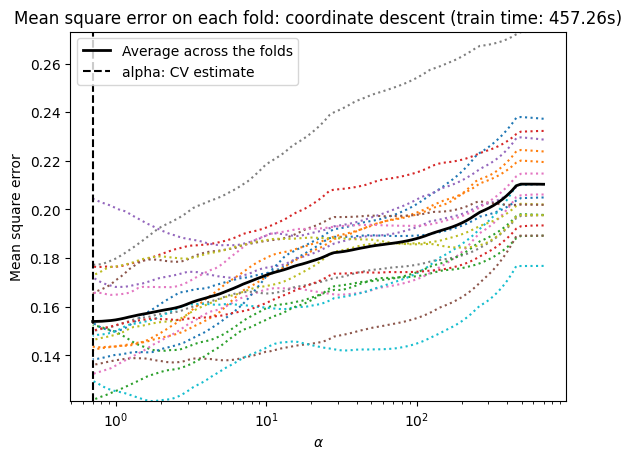

In [14]:
lasso_model, lasso_alpha = get_best_alpha_lasso(path_lasso_model, f'alpha_lasso_{tag}.png', X_train, y_train_binary, cv = 20, lars=False)
print(f'Best alpha {lasso_alpha}')

In [15]:
coef = np.abs(lasso_model.coef_)
f_coef = [i for i in coef if i > 1e-6]
k=len(f_coef)
#k=87
print(f'Number of elements different from 0: {k}')
important_genes = coef.argsort()[-k:][::-1]

Number of elements different from 0: 175


In [16]:
X_train_balance_selected = X_train_balance.iloc[:, important_genes]
X_test_balance_selected = X_test.iloc[:, important_genes]
df_results = evaluate_models(f'lasso_accuracy_{tag}_{k}_features', "f1", X_train_balance_selected, X_test_balance_selected, y_train_binary_balance, y_test_binary, df_results, df_result_file)

---SVC---
Fitting 5 folds for each of 40 candidates, totalling 200 fits


Grid best score: 0.8500871954951821
Grid best parameters: LinearSVC(C=1, class_weight='balanced', dual='auto')
Test accuracy score 0.792
Test precision score 0.892
Test recall score 0.796
Test f1 score 0.841
Test accuracy per category: [0.78321678 0.79566563]
---Random Forest---
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Grid best score: 0.8739184173106682
Grid best parameters: RandomForestClassifier(n_estimators=400)
Test accuracy score 0.803
Test precision score 0.860
Test recall score 0.854
Test f1 score 0.857
Test accuracy per category: [0.68531469 0.85448916]
---Logistic Regression---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Grid best score: 0.8454532113607188
Grid best parameters: LogisticRegression(class_weight='balanced', max_iter=10000, penalty=None,
                   random_state=42)
Test accuracy score 0.790
Test precision score 0.889
Test recall score 0.796
Test f1 score 0.840
Test accuracy per category: [0.77622378 0.79566563]


In [ ]:
for i in range(50, 250, 50):
    print(f'N features: {i}')
    dict_train_features, dict_test_features = load_lasso_df_coef(i, path_lasso_model, f'model_lasso_{tag}_lars.pkl', X_train_balance, pd.DataFrame(y_train_binary_balance), X_test, lars=True, cv=5)
    df_results = evaluate_booting_models(f'lasso_{tag}_{i}_features', dict_train_features, dict_test_features, y_train_binary_balance, y_test_binary, df_results, df_result_file)

In [27]:
df_results_tmp = pd.read_csv(df_result_file)
df_results_tmp = filter_df_results(df_results_tmp, 3, 0.78)
df_results_tmp.head(10)

,Model Name,Dataset Name,Accuracy Category 0,Accuracy Category 1,Overall Accuracy,Precision,Recall,F1-Score
25,RForest,lasso_accuracy_binary_90_features,0.553957,0.885993,0.782511,0.814371,0.885993,0.848674
52,RForest,lasso_accuracy_binary_180_features,0.553957,0.885993,0.782511,0.814371,0.885993,0.848674
55,RForest,lasso_accuracy_binary_190_features,0.553957,0.882736,0.780269,0.813814,0.882736,0.846875
67,RForest,lasso_accuracy_binary_230_features,0.575540,0.876221,0.782511,0.820122,0.876221,0.847244
124,RForest,lasso_f1_binary_180_features,0.568345,0.876221,0.780269,0.817629,0.876221,0.845912
136,RForest,lasso_f1_binary_220_features,0.553957,0.885993,0.782511,0.814371,0.885993,0.848674
139,RForest,lasso_f1_binary_230_features,0.575540,0.876221,0.782511,0.820122,0.876221,0.847244
151,LightGBM,lasso_binary_200_features,0.604317,0.859935,0.780269,0.827586,0.859935,0.843450


#### Run Lasso selection with XGBoost and LightGBM models

In [ ]:
dict_train_features, dict_test_features = load_lasso_df_coef(345, path_lasso_model, f'model_lasso_{tag}_lars.pkl', X_train_balance, pd.DataFrame(y_train_multiclass_balance), X_test, lars=True, cv=5)
grid_XGBoost = train_hyper_XGBoost(dict_train_features, y_train_multiclass_balance, -1)
grid_LightGBM = train_hyper_LightGBM(dict_train_features, y_train_multiclass_balance, -1)

In [22]:
graph_genes_importance(grid_LightGBM.best_estimator_.feature_importances_)

In [30]:
df_results_tmp = pd.read_csv(df_result_file)
df_results_tmp = filter_df_results(df_results_tmp, 5, 0.80)
df_results_tmp.head(10)

,Model Name,Dataset Name,Accuracy Category 0,Accuracy Category 1,Overall Accuracy,Precision,Recall,F1-Score


### Regularization methods (Elastic Net (L1 and L2) regression)

In [17]:
def load_elasticnet_model(file_elasticnet_model, X_train, y_train):
    if os.path.exists(file_elasticnet_model):
        elasticnet_model = joblib.load(file_elasticnet_model)
    else:
        with warnings.catch_warnings():
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                elasticnet_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=5, n_jobs=-1).fit(X_train, y_train)
                joblib.dump(elasticnet_model, file_elasticnet_model)
    return elasticnet_model

In [18]:
# Load or calc if not exist lasso coefficients
def load_elasticnet_df_coef(file_elasticnet_path, k, X_train, y_train):
    dict_dfs = {}    
    elasticnet_model = load_elasticnet_model(file_elasticnet_path, X_train, y_train)
    coef = np.abs(elasticnet_model.coef_)
    # Create a datasets with features that have coefficients
    # greater than a threshold (0.1 to 1e-10)
    for i in [pow(10, -i) for i in range(2, k+1)]:
        n_nonzero = len(np.where(abs(coef) >= i)[0])
        if (n_nonzero != 0):
            print(f'Number of elements different from 0: {n_nonzero}')
            important_genes = coef.argsort()[-n_nonzero:][::-1]
            dict_dfs[n_nonzero] = X_train.iloc[:, important_genes]
    return dict_dfs

In [19]:
tag = "binary"
dict_binaries_features = load_elasticnet_df_coef(file_elasticnet_model, 10, X_train_balance, y_train_binary_balance)
#save_datasets(f'Data/{outlier_folder}/ElasticNet_{tag}', f'{tag}_elasticnet', dict_binaries_features)

Number of elements different from 0: 69
Number of elements different from 0: 179
Number of elements different from 0: 206
Number of elements different from 0: 208
Number of elements different from 0: 210
Number of elements different from 0: 210
Number of elements different from 0: 210


In [20]:
for n_features, dict_feature_selected in dict_binaries_features.items():
    len(dict_feature_selected)
    print(n_features, len(dict_feature_selected))

69 2606
179 2606
206 2606
208 2606
210 2606


In [21]:
for n_features, dict_feature_selected in dict_binaries_features.items():
    print(f'N features: {n_features}')
    features_selected = dict_feature_selected.columns.tolist()
    X_test_selected = X_test[features_selected]
    df_results = evaluate_models(f'ElasticNet_accuracy_{tag}_{n_features}_features', "accuracy", dict_feature_selected, X_test_selected, y_train_binary_balance, y_test_binary, df_results, df_result_file)
    df_results = evaluate_models(f'ElasticNet_f1_{tag}_{n_features}_features', "f1", dict_feature_selected, X_test_selected, y_train_binary_balance, y_test_binary, df_results, df_result_file)


N features: 69
---SVC---
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Grid best score: 0.8311646480022944
Grid best parameters: LinearSVC(C=0.1, class_weight='balanced', dual='auto', tol=0.1)
Test accuracy score 0.781
Test precision score 0.888
Test recall score 0.783
Test f1 score 0.832
Test accuracy per category: [0.77622378 0.78328173]
---Random Forest---
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Grid best score: 0.8752994903699782
Grid best parameters: RandomForestClassifier(n_estimators=200)
Test accuracy score 0.760
Test precision score 0.821
Test recall score 0.836
Test f1 score 0.828
Test accuracy per category: [0.58741259 0.83591331]
---Logistic Regression---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Grid best score: 0.8280936307278223
Grid best parameters: LogisticRegression(class_weight='balanced', max_iter=10000, random_state=42,
                   solver='saga')
Test accuracy score 0.785
Test precision score 0.883
Test 

In [ ]:
for n_features, dict_feature_selected in dict_binaries_features.items():
    print(f'N features: {n_features}')
    features_selected = dict_feature_selected.columns.tolist()
    X_test_selected = X_test[features_selected]
    df_results = evaluate_booting_models(f'ElasticNet_{tag}_{i}_features', dict_feature_selected, X_test_selected, y_train_binary_balance, y_test_binary, df_results, df_result_file)

In [38]:
df_results_tmp = pd.read_csv(df_result_file)
df_results_tmp = filter_df_results(df_results_tmp, 5, 0.78)
df_results_tmp.head(10)

,Model Name,Dataset Name,Accuracy Category 0,Accuracy Category 1,Overall Accuracy,Precision,Recall,F1-Score
25,RForest,lasso_accuracy_binary_90_features,0.553957,0.885993,0.782511,0.814371,0.885993,0.848674
52,RForest,lasso_accuracy_binary_180_features,0.553957,0.885993,0.782511,0.814371,0.885993,0.848674
55,RForest,lasso_accuracy_binary_190_features,0.553957,0.882736,0.780269,0.813814,0.882736,0.846875
67,RForest,lasso_accuracy_binary_230_features,0.575540,0.876221,0.782511,0.820122,0.876221,0.847244
124,RForest,lasso_f1_binary_180_features,0.568345,0.876221,0.780269,0.817629,0.876221,0.845912
136,RForest,lasso_f1_binary_220_features,0.553957,0.885993,0.782511,0.814371,0.885993,0.848674
139,RForest,lasso_f1_binary_230_features,0.575540,0.876221,0.782511,0.820122,0.876221,0.847244
151,LightGBM,lasso_binary_200_features,0.604317,0.859935,0.780269,0.827586,0.859935,0.843450
153,RForest,ElasticNet_accuracy_binary_200_features,0.604317,0.859935,0.780269,0.827586,0.859935,0.843450


### Wrapper methods (Recursive Feauture Elimination(RFE) and sequential forward or back selection)

In [58]:
min_features_to_select = 1  # Minimum number of features to consider
cv = StratifiedKFold(5)
#LinearSVC(dual=True, max_iter=10000), LogisticRegression(solver='lbfgs', max_iter=1000, n_jobs=-1), RandomForestClassifier()
estimators = [LinearSVC(dual="auto", max_iter=1000),
            LogisticRegression(solver='lbfgs', max_iter=1000, n_jobs=-1),
            RandomForestClassifier(n_jobs=-1)]
df_rfe_results = pd.DataFrame(columns=['Estimator', 'Optimal number of features', 'Max score', 'Elapsed time'])
rfe_fitted = {}

for estimator in estimators:
    rfecv = RFECV(
        estimator=estimator,
        step=10,
        cv=cv,
        scoring="accuracy",
        min_features_to_select=min_features_to_select,
        n_jobs=-1,
    )
    start_time = time.time()
    rfecv.fit(X_train_balance, y_train_multiclass_balance)
    fit_time = time.time() - start_time  
    rfe_fitted[type(estimator).__name__] = rfecv
    print(f'Estimator: {estimator.__class__.__name__}, Optimal number of features:  {rfecv.n_features_}, Max score:  {rfecv.cv_results_["mean_test_score"]}')
    scores = rfecv.cv_results_['mean_test_score']
    rfe_data = {
        'Estimator': [estimator.__class__.__name__],
        'Optimal number of features': [rfecv.n_features_],
        'Max score':[max(scores)],
        'Elapsed time': [f"{fit_time:.4f}"]
    }
    df_rfe_results = pd.concat([df_rfe_results, pd.DataFrame(rfe_data)], ignore_index=True)

send_notification(token, chat_id, 'Terminó RFE')

c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Edel\.virtualenvs\Des

In [5]:
save_dataframe_to_csv(df_rfe_results, df_rfecv_file)
save_pickle_object(rfe_fitted, list_rfecv_objects_file)

NameError: name 'df_rfe_results' is not defined

In [24]:
rfecv_list_ = load_pickle_object(list_rfecv_objects_file)

Object has been loaded from d:\DataScience_and_Python\Magister_IA_VIU\TFM\Desarrollo\TPM/WO_RFECV_objects.pkl.


In [25]:
df_rfe_results = pd.read_csv(df_rfecv_file)
df_rfe_results.head(4)

,Estimator,Optimal number of features,Max score,Elapsed time
0,LinearSVC,2583,0.898707,3436.9964
1,LogisticRegression,1153,0.892949,6195.6070
2,RandomForestClassifier,1013,0.875300,8317.3877


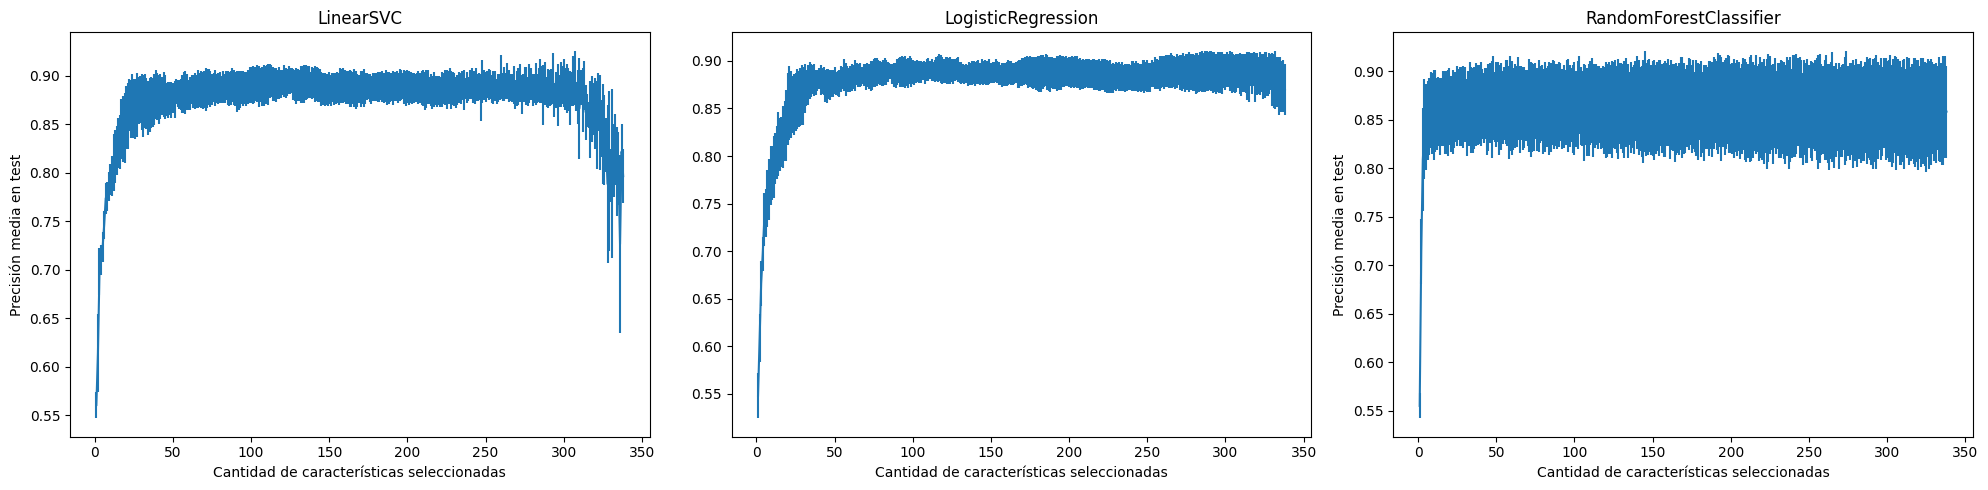

In [26]:
min_features_to_select = 1
rfecv_svc = rfecv_list_['LinearSVC']
n_scores_SVC = len(rfecv_svc.cv_results_["mean_test_score"])
scores_SVC = rfecv_svc.cv_results_['mean_test_score']

rfecv_lr = rfecv_list_['LogisticRegression']
n_scores_LR = len(rfecv_lr.cv_results_["mean_test_score"])
scores_LR = rfecv_lr.cv_results_['mean_test_score']

rfecv_rf = rfecv_list_['RandomForestClassifier']
n_scores_RF = len(rfecv_rf.cv_results_["mean_test_score"])
scores_RF = rfecv_rf.cv_results_['mean_test_score']

fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Grafico 1 (LinearSVC)
axs[0].errorbar(
    range(min_features_to_select, n_scores_SVC + min_features_to_select),
    scores_SVC,
    yerr=rfecv_svc.cv_results_["std_test_score"],
)
#axs[0].set_xlabel("Number of features selected")
axs[0].set_xlabel("Cantidad de características seleccionadas")
#axs[0].set_ylabel("Mean test accuracy")
axs[0].set_ylabel("Precisión media en test")
axs[0].set_title("LinearSVC")

# Grafico 2 (LogisticRegression)
axs[1].errorbar(
    range(min_features_to_select, n_scores_LR + min_features_to_select),
    scores_LR,
    yerr=rfecv_lr.cv_results_["std_test_score"],
)
#axs[1].set_xlabel("Number of features selected")
axs[1].set_xlabel("Cantidad de características seleccionadas")
#axs[1].set_ylabel("Mean test accuracy")
axs[0].set_ylabel("Precisión media en test")
axs[1].set_title("LogisticRegression")

# Grafico 3 (RandomForestClassifier)
axs[2].errorbar(
    range(min_features_to_select, n_scores_RF + min_features_to_select),
    scores_RF,
    yerr=rfecv_rf.cv_results_["std_test_score"],
)
#axs[2].set_xlabel("Number of features selected")
axs[2].set_xlabel("Cantidad de características seleccionadas")
#axs[2].set_ylabel("Mean test accuracy")
axs[2].set_ylabel("Precisión media en test")
axs[2].set_title("RandomForestClassifier")

# Ajustar espaciado entre los gráficos
plt.tight_layout()

# Mostrar los gráficos
plt.show()

In [27]:
def get_first_features(threshold):
    # Find the first value greater than the threshold along with its index
    all_scores = {'SVC':scores_SVC, 'LR':scores_LR, 'RF':scores_RF}
    for name, score_i in all_scores.items():
        item = next(((i, score) for i, score in enumerate(score_i) if score >= threshold), None)
        if item is not None:
            print(f"{name}: The first value greater than {threshold} is {item[0]} at index {item[1]}")
        else:
            print(f"{name}: No value greater than {threshold} was found")

get_first_features(0.90)
print('---------------')
get_first_features(0.89)
print('---------------')
get_first_features(0.88)
print('---------------')
get_first_features(0.87)

SVC: No value greater than 0.9 was found
LR: No value greater than 0.9 was found
RF: No value greater than 0.9 was found
---------------
SVC: The first value greater than 0.89 is 83 at index 0.8902611394238902
LR: The first value greater than 0.89 is 97 at index 0.8902618748207469
RF: No value greater than 0.89 was found
---------------
SVC: The first value greater than 0.88 is 38 at index 0.8806700936160198
LR: The first value greater than 0.88 is 35 at index 0.8806671520285922
RF: No value greater than 0.88 was found
---------------
SVC: The first value greater than 0.87 is 27 at index 0.8745302652576463
LR: The first value greater than 0.87 is 30 at index 0.8710797832050066
RF: The first value greater than 0.87 is 47 at index 0.8726182334296704


In [42]:
rfecv_SVC = rfecv_list_['LinearSVC']
rfecv_LR = rfecv_list_['LogisticRegression']
n_features = len(rfecv_SVC.cv_results_['mean_test_score'])
grid_scores_SVC = rfecv_SVC.cv_results_['mean_test_score']
grid_scores_LR = rfecv_LR.cv_results_['mean_test_score']

optimal_num_features_SVC = np.argmax(grid_scores_SVC) + 1
optimal_num_features_LR = np.argmax(grid_scores_LR) + 1

# Define un conjunto de valores en el eje X para agregar líneas verticales azules
values_to_mark_blue_SVC = [22, 28, 39, 88]  # Puedes ajustar estos valores según tus necesidades
values_to_mark_blue_LR = [31, 36, 98 ]

# Crea un DataFrame con los datos para el primer objeto RFECV
data_svc = pd.DataFrame({'Number of features selected': range(1, n_features + 1),
                         'Mean Test Accuracy (SVC)': grid_scores_SVC})

# Crea un DataFrame con los datos para el otro objeto RFECV
data_lr = pd.DataFrame({'Number of features selected': range(1, n_features + 1),
                           'Mean Test Accuracy (LR)': grid_scores_LR})

# Crea la gráfica con Plotly Express
fig = px.line(title="Mean Test Accuracy vs. Number of Features Selected",
              labels={'Number of features selected': 'Number of Features Selected', 'value': 'Mean Test Accuracy'},
              range_x=[1, 280])  # Establece el rango deseado en el eje X

# Agrega los datos de los scores para ambos objetos
fig.add_trace(px.line(data_svc, x='Number of features selected', y='Mean Test Accuracy (SVC)').data[0].update(line=dict(color='darkblue')))
fig.add_trace(px.line(data_lr, x='Number of features selected', y='Mean Test Accuracy (LR)').data[0].update(line=dict(color='chocolate')))

pos_up = False
# Agrega líneas verticales azules en los valores definidos en values_to_mark_blue
for value in values_to_mark_blue_SVC:
    index = int(value + 1)  # Índice correspondiente al valor en el eje X
    score_svc = grid_scores_SVC[index]
    score_other = grid_scores_LR[index]
    annotation_text = f'SVC: {score_svc:.4f}<br>N Features: {int(value)}'
    annotation_position = "left" if pos_up else "bottom left"
    fig.add_vline(x=value, line_dash="dash", line_color="darkcyan",
                annotation_text=annotation_text,
                annotation_position=annotation_position,
                annotation_font_color="darkcyan")    
    pos_up = not pos_up

fig.update_annotations(font=dict(size=9))

pos_up = False
for value in values_to_mark_blue_LR:
    index = int(value + 1)  # Índice correspondiente al valor en el eje X
    score_lr = grid_scores_LR[index]
    annotation_text = f'LR: {score_lr:.4f}<br>N Features: {int(value)}'
    annotation_position = "right" if pos_up else "bottom right"
    fig.add_vline(x=value, line_dash="dash", line_color="coral",
                annotation_text=annotation_text,
                annotation_position=annotation_position,
                annotation_font_color="coral")    
    pos_up = not pos_up

fig.update_annotations(font=dict(size=9))

# Agrega una línea vertical en el número óptimo de variables para ambos objetos (en rojo)
optimal_score_svc = grid_scores_SVC[optimal_num_features_SVC - 1]
optimal_score_LR = grid_scores_LR[optimal_num_features_LR - 1]

optimal_annotation_text_SVC = f'SVC Optimal Features: {optimal_num_features_SVC}<br>SVC Optimal Score: {optimal_score_svc:.4f}'
fig.add_vline(x=optimal_num_features_SVC, line_dash="dash", line_color="red",
            annotation_text=optimal_annotation_text_SVC,
            annotation_position='right',
            annotation_font_color="red")

optimal_annotation_text_LR = f'LR Optimal Features: {optimal_num_features_LR}<br>LR Optimal Score: {optimal_score_LR:.4f}'
fig.add_vline(x=optimal_num_features_LR, line_dash="dash", line_color="red",
            annotation_text=optimal_annotation_text_LR,
            annotation_position='left',
            annotation_font_color="red")

# Muestra la gráfica interactiva
fig.show()

In [41]:
values_to_mark_blue_SVC = [22, 28, 38, 84]
tag = "binary"
n_feature = 0
file_RFE_fitted_SVC = f'{base_folder}/WO_RFE_fitted_{tag}_n_feature_feature_LinearSVC.pkl'

for i in values_to_mark_blue_SVC:
    file_name = file_RFE_fitted_SVC.replace('n_feature', str(i))
    if os.path.exists(file_RFE_fitted_SVC):
        selector_SVC = load_pickle_object(file_name)
    else:
        selector_SVC = RFE(LinearSVC(dual="auto", max_iter=1000), n_features_to_select=i, step=1)
        selector_SVC.fit_transform(X_train_balance, y_train_binary_balance)
        save_pickle_object(selector_SVC, file_name)

    X_train_selected_rfe_SVC = X_train_balance[selector_SVC.get_feature_names_out()]
    X_test_selected_rfe_SVC = X_test[selector_SVC.get_feature_names_out()]
    df_results = evaluate_models(f'RFE_SVC_accuracy_{tag}_{i}_features', "accuracy", X_train_selected_rfe_SVC, X_test_selected_rfe_SVC, y_train_binary_balance, y_test_binary, df_results, df_result_file)

send_notification(token, chat_id, 'Terminó RFE SVC')


c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWa

Object has been saved to d:\DataScience_and_Python\Magister_IA_VIU\TFM\Desarrollo\TPM/WO_RFE_fitted_binary_22_feature_LinearSVC.pkl.
---SVC---
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Grid best score: 0.7455865157632316
Grid best parameters: LinearSVC(C=0.1, class_weight='balanced', dual='auto', tol=0.01)
Test accuracy score 0.659
Test precision score 0.813
Test recall score 0.659
Test f1 score 0.728
Test accuracy per category: [0.65734266 0.65944272]
---Random Forest---
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Grid best score: 0.8208132018443752
Grid best parameters: RandomForestClassifier(n_estimators=400)
Test accuracy score 0.738
Test precision score 0.809
Test recall score 0.814
Test f1 score 0.812
Test accuracy per category: [0.56643357 0.81424149]
---Logistic Regression---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Grid best score: 0.7448209676351844
Grid best parameters: LogisticRegression(class_weight='balanced', max_it

c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWa

Object has been saved to d:\DataScience_and_Python\Magister_IA_VIU\TFM\Desarrollo\TPM/WO_RFE_fitted_binary_28_feature_LinearSVC.pkl.
---SVC---
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Grid best score: 0.7620895566292349
Grid best parameters: LinearSVC(C=0.01, class_weight='balanced', dual='auto', tol=0.001)
Test accuracy score 0.665
Test precision score 0.817
Test recall score 0.666
Test f1 score 0.734
Test accuracy per category: [0.66433566 0.66563467]
---Random Forest---
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Grid best score: 0.8384671387914489
Grid best parameters: RandomForestClassifier(n_estimators=200)
Test accuracy score 0.719
Test precision score 0.791
Test recall score 0.808
Test f1 score 0.799
Test accuracy per category: [0.51748252 0.80804954]
---Logistic Regression---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Grid best score: 0.7636243298696141
Grid best parameters: LogisticRegression(class_weight='balanced', max_

c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWa

Object has been saved to d:\DataScience_and_Python\Magister_IA_VIU\TFM\Desarrollo\TPM/WO_RFE_fitted_binary_38_feature_LinearSVC.pkl.
---SVC---
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Grid best score: 0.7904891124495335
Grid best parameters: LinearSVC(C=0.1, class_weight='balanced', dual='auto', tol=0.001)
Test accuracy score 0.652
Test precision score 0.797
Test recall score 0.669
Test f1 score 0.727
Test accuracy per category: [0.61538462 0.66873065]
---Random Forest---
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Grid best score: 0.8365514299791883
Grid best parameters: RandomForestClassifier(n_estimators=300)
Test accuracy score 0.725
Test precision score 0.788
Test recall score 0.827
Test f1 score 0.807
Test accuracy per category: [0.4965035  0.82662539]
---Logistic Regression---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Grid best score: 0.787803443128084
Grid best parameters: LogisticRegression(class_weight='balanced', max_it

c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWa

Object has been saved to d:\DataScience_and_Python\Magister_IA_VIU\TFM\Desarrollo\TPM/WO_RFE_fitted_binary_84_feature_LinearSVC.pkl.
---SVC---
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Grid best score: 0.8461336510247754
Grid best parameters: LinearSVC(C=0.1, class_weight='balanced', dual='auto')
Test accuracy score 0.708
Test precision score 0.819
Test recall score 0.743
Test f1 score 0.779
Test accuracy per category: [0.62937063 0.74303406]
---Random Forest---
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Grid best score: 0.8538170773858113
Grid best parameters: RandomForestClassifier(n_estimators=300)
Test accuracy score 0.736
Test precision score 0.801
Test recall score 0.824
Test f1 score 0.812
Test accuracy per category: [0.53846154 0.82352941]
---Logistic Regression---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Grid best score: 0.8469021407402504
Grid best parameters: LogisticRegression(class_weight='balanced', max_iter=10000, 

In [ ]:
values_to_mark_blue_LR = [31, 36, 98]
tag = "binary"
n_feature = 0
file_RFE_fitted_LR = f'{base_folder}/WO_RFE_fitted_{tag}_n_feature_feature_LinearLR.pkl'

for i in values_to_mark_blue_LR:
    file_name = file_RFE_fitted_LR.replace('n_feature', str(i))
    if os.path.exists(file_RFE_fitted_LR):
        selector_LR = load_pickle_object(file_name)
    else:
        selector_LR = RFE(LogisticRegression(solver='lbfgs', max_iter=1000, n_jobs=-1), n_features_to_select=i, step=1)
        selector_LR.fit_transform(X_train_balance, y_train_binary_balance)
        save_pickle_object(selector_LR, file_name)

    X_train_selected_rfe_LR = X_train_balance[selector_LR.get_feature_names_out()]
    X_test_selected_rfe_LR = X_test[selector_LR.get_feature_names_out()]
    df_results = evaluate_models(f'RFE_LR_accuracy_{tag}_{i}_features', "accuracy", X_train_selected_rfe_LR, X_test_selected_rfe_LR, y_train_binary_balance, y_test_binary, df_results, df_result_file)

send_notification(token, chat_id, 'Terminó RFE LR')

In [ ]:
df_results_tmp = pd.read_csv(df_result_file)

In [ ]:
best_balance = df_results_tmp[abs(df_results_tmp['Accuracy Category 0'] - df_results_tmp['Accuracy Category 1']) < 0.1]
print(f'Number of selected training: {best_balance.shape}')
best_balance = best_balance.sort_values(by='Accuracy Category 0', ascending=False)
best_balance

Number of selected training: (45, 8)


,Model Name,Dataset Name,Accuracy Category 0,Accuracy Category 1,Overall Accuracy,Precision,Recall,F1-Score
68,LOGR,lasso_binary_225_features,0.794118,0.781250,0.785714,0.877193,0.781250,0.826446
175,SVC,ElasticNet_binary_345_features,0.794118,0.765625,0.775510,0.875000,0.765625,0.816667
80,LOGR,lasso_binary_265_features,0.794118,0.812500,0.806122,0.881356,0.812500,0.845528
83,LOGR,lasso_binary_275_features,0.794118,0.796875,0.795918,0.879310,0.796875,0.836066
56,LOGR,lasso_binary_185_features,0.794118,0.765625,0.775510,0.875000,0.765625,0.816667
54,SVC,lasso_binary_185_features,0.794118,0.734375,0.755102,0.870370,0.734375,0.796610
69,SVC,lasso_binary_235_features,0.794118,0.703125,0.734694,0.865385,0.703125,0.775862
74,LOGR,lasso_binary_245_features,0.794118,0.781250,0.785714,0.877193,0.781250,0.826446
177,LOGR,ElasticNet_binary_345_features,0.794118,0.812500,0.806122,0.881356,0.812500,0.845528
180,SVC,RFE_SVC_binary_98_features,0.794118,0.703125,0.734694,0.865385,0.703125,0.775862


In [ ]:
best_accuracies = df_results_tmp[df_results_tmp['Overall Accuracy'] >= 0.80]
print(f'Number of selected training: {best_accuracies.shape}')
best_accuracies = best_accuracies.sort_values(by='Overall Accuracy', ascending=False)
best_accuracies

Number of selected training: (5, 8)


,Model Name,Dataset Name,Accuracy Category 0,Accuracy Category 1,Overall Accuracy,Precision,Recall,F1-Score
192,SVC,RFE_LR_binary_282_features,0.764706,0.843750,0.816327,0.870968,0.843750,0.857143
80,LOGR,lasso_binary_265_features,0.794118,0.812500,0.806122,0.881356,0.812500,0.845528
100,RForest,lasso_binary_335_features,0.558824,0.937500,0.806122,0.800000,0.937500,0.863309
177,LOGR,ElasticNet_binary_345_features,0.794118,0.812500,0.806122,0.881356,0.812500,0.845528
182,LOGR,RFE_SVC_binary_98_features,0.764706,0.828125,0.806122,0.868852,0.828125,0.848000


In [ ]:
best_accuracy_0 = df_results_tmp[df_results_tmp['Accuracy Category 0'] >= 0.80]
print(f'Number of selected training: {best_accuracy_0.shape}')
best_accuracy_0 = best_accuracy_0.sort_values(by='Accuracy Category 0', ascending=False)
best_accuracy_0

Number of selected training: (1, 8)


,Model Name,Dataset Name,Accuracy Category 0,Accuracy Category 1,Overall Accuracy,Precision,Recall,F1-Score
51,SVC,lasso_binary_175_features,0.911765,0.671875,0.755102,0.934783,0.671875,0.781818


In [ ]:
best_accuracy_1 = df_results_tmp[df_results_tmp['Accuracy Category 1'] >= 0.94]
print(f'Number of selected training: {best_accuracy_0.shape}')
best_accuracy_1 = best_accuracy_1.sort_values(by='Accuracy Category 1', ascending=False)
best_accuracy_1

Number of selected training: (1, 8)


,Model Name,Dataset Name,Accuracy Category 0,Accuracy Category 1,Overall Accuracy,Precision,Recall,F1-Score
40,RForest,lasso_binary_135_features,0.5,0.953125,0.795918,0.782051,0.953125,0.859155


In [ ]:
#Best Models
best_models = [('SVC', 'RFE_LR_binary_62_features'), ('LOGR', 'lasso_binary_85_features'), ('LOGR', 'lasso_binary_165_features')]

all_condicions = pd.Series(False, index=df_results_tmp.index)
for model_name, dataset_name in best_models:
    actual_condition = (df_results_tmp['Model Name'] == model_name) & (df_results_tmp['Dataset Name'] == dataset_name)
    all_condicions = all_condicions | actual_condition
df_best_models = df_results_tmp[all_condicions]
df_best_models


,Model Name,Dataset Name,Accuracy Category 0,Accuracy Category 1,Overall Accuracy,Precision,Recall,F1-Score
26,LOGR,lasso_binary_85_features,0.647059,0.781250,0.734694,0.806452,0.781250,0.793651
50,LOGR,lasso_binary_165_features,0.705882,0.734375,0.724490,0.824561,0.734375,0.776860


### Tests with specific amounts of genes

In [ ]:
k = 98 # number of features (genes) to select
#df_genes_labels_file =f'Data/{outlier_folder}/df_expression_data_rfe_{k}_thrombo.pkl'
df_genes_labels_file =f'Data/with_outliers/df_expression_data_rfe_thrombo.pkl'
if os.path.exists(df_genes_labels_file):
    df_expression_data_selected_rfe = pd.read_pickle(df_genes_labels_file)
else:
    selector = RFE(LogisticRegression(n_jobs=-1), n_features_to_select=k, step=1)
    expression_data_selected_rfe = selector.fit_transform(X_train, y_train_binary)
    df_expression_data_selected_rfe = expression_data[selector.get_feature_names_out()]
    df_expression_data_selected_rfe.to_pickle(df_genes_labels_file)

In [ ]:
genes_selected = df_expression_data_selected_rfe.columns.to_list()
len(genes_selected)

178

In [ ]:
X_train_selected = X_train_balance[genes_selected]
X_test_selected = X_test[genes_selected]
df_results = evaluate_models(f'RFE_{tag}_{len(genes_selected)}_features', X_train_selected, X_test_selected, y_train_binary_balance, y_test_binary, df_results, df_result_file)

---SVC---
Fitting 5 folds for each of 224 candidates, totalling 1120 fits
Grid best score: 0.9287502267368041
Grid best parameters: SVC(C=10, class_weight='balanced', gamma='auto', tol=0.1)
Test accuracy score 0.898
Test accuracy per category: [0.82352941 0.9375    ]
---Random Forest---
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Grid best score: 0.8702908282148105
Grid best parameters: RandomForestClassifier(max_depth=80, min_samples_leaf=4, min_samples_split=8,
                       n_estimators=200)
Test accuracy score 0.755
Test accuracy per category: [0.58823529 0.84375   ]
---Logistic Regression---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Grid best score: 0.9158570767380976
Grid best parameters: LogisticRegression(class_weight='balanced', max_iter=10000, penalty=None,
                   random_state=42)
Test accuracy score 0.888
Test accuracy per category: [0.76470588 0.953125  ]


In [ ]:
df_results = evaluate_booting_models(f'RFE_{tag}_{len(genes_selected)}_features', X_train_selected, X_test_selected, y_train_binary, y_test_binary, df_results, df_result_file)

---XGBoost---
Fitting 5 folds for each of 27 candidates, totalling 135 fits


Grid best score: 0.7794103194103195
Grid best parameters: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
Test accuracy score 0.724
Test accuracy per category: [0.41176471 0.890625  ]
---LightGBM ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Grid best score: 0.8083210483210482
Gr

### Particle Swarm Optimization (PSO)

In [ ]:
class GeneSelection:
    def __init__(self, X, y, n_genes=10):
        self.X = X
        self.y = y
        self.n_genes = n_genes
        self.swarm = []
        self.best_solution = None
        self.best_accuracy = 0

    def generate_swarm(self, swarm_size=100):
        for i in range(swarm_size):
            particle = np.random.randint(0, self.X.shape[1], self.n_genes)
            self.swarm.append(particle)

    def evaluate_particle(self, particle):
        X_selected = self.X.iloc[:, particle]
        X_train, X_test, y_train, y_test = train_test_split(X_selected, self.y, test_size=0.25)
        clf = LogisticRegression(max_iter=250, n_jobs=-1)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = np.mean(y_pred == y_test)
        return accuracy

    def select_best_particles(self):
        accuracy = []
        for particle in self.swarm:
            accuracy.append(self.evaluate_particle(particle))

        self.best_solution = self.swarm[np.argmax(accuracy)]
        self.best_accuracy = np.max(accuracy)

    def update_swarm(self):
        for particle in self.swarm:
            # Calculate the particle's velocity
            v = np.random.uniform(-1, 1, self.n_genes)

            # Update the particle's position
            particle = particle + v

            # Clip the particle's position to the bounds of the search space
            particle = np.clip(particle, 0, self.X.shape[1] - 1)

    def evolve(self, num_iterations=100):
        for i in range(num_iterations):
            self.update_swarm()
            self.select_best_particles()

    def get_best_solution(self):
        return self.best_solution, self.best_accuracy

# Example usage:

gene_selection = GeneSelection(X_train_balance, y_train_binary_balance)
gene_selection.generate_swarm()
gene_selection.evolve()

best_solution, best_accuracy = gene_selection.get_best_solution()

print('Best solution:', best_solution)
print('Best accuracy:', best_accuracy)

In [ ]:
indices = [i for i, valor in enumerate(best_solution) if valor == 1]
X_train_selected = X_train_balance.iloc[:, indices]
X_test_selected = X_test.iloc[:, indices]
df_results = evaluate_models(f'PSO_{tag}_{len(indices)}_ accuracy_features',  "accuracy", X_train_selected, X_test_selected, y_train_binary_balance, y_test_binary, df_results, df_result_file)

In [16]:
def evaluate_models_pso(X, y, best_solution=None):
    if best_solution is None:
        best_solution = np.arange(X.shape[1])
    # Seleccionamos las variables
    X_selected = X.iloc[:, best_solution]

    # Entrenamos los modelos
    svm = SVC()
    rf = RandomForestClassifier(n_jobs=-1)
    lr = LogisticRegression(max_iter=250, n_jobs=-1)
    svm.fit(X_selected, y)
    rf.fit(X_selected, y)
    lr.fit(X_selected, y)

    # Evaluamos los modelos
    scores = []
    scores.append(svm.score(X_selected, y))
    scores.append(rf.score(X_selected, y))
    scores.append(lr.score(X_selected, y))

    return scores

def ebspo(func, n_iter=100, n_particles=100, dimensions=10, options={'c1': 0.5, 'c2': 0.5, 'w': 0.9}):
    # Inicializamos la población
    swarm = np.random.binomial(1, 0.5, (n_particles, dimensions))

    # Evaluamos la población
    fitness = np.array([func(particle) for particle in swarm])

    # Seleccionamos la mejor solución
    best_particle = swarm[np.argmax(fitness)]
    best_fitness = fitness[np.argmax(fitness)]

    # Ejecutamos el algoritmo
    for i in range(n_iter):
        # Actualizamos la velocidad de las partículas
        v = np.random.uniform(-1, 1, (n_particles, dimensions))
        v = options['w'] * v + options['c1'] * (best_particle - swarm) + options['c2'] * (random.choice(swarm) - swarm)

        # Actualizamos la posición de las partículas
        swarm = swarm + v
        swarm = np.clip(swarm, 0, 1)

        # Evaluamos la nueva población
        fitness = np.array([func(particle) for particle in swarm])

        # Actualizamos la mejor solución
        if np.sum(fitness[np.argmax(fitness)]) > np.sum(best_fitness):
            best_particle = swarm[np.argmax(fitness)]
            best_fitness = fitness[np.argmax(fitness)]
            print(best_particle)
            print(best_fitness)

    return best_particle, best_fitness

# Ejemplo de uso:

# Función de evaluación
def fitness(solution):
    return evaluate_models_pso(X_train_balance, y_train_binary_balance, solution)

best_solution, best_fitness = ebspo(func=fitness, n_iter=50, n_particles=100, dimensions=X_train_balance.shape[1])

print('Best solution:', best_solution)
print('Best fitness:', best_fitness)

Best solution: [1 1 1 ... 0 1 1]
Best fitness: [0.57447699 0.99623431 0.541841  ]


In [18]:
indices = [i for i, valor in enumerate(best_solution) if valor == 1]
X_train_selected = X_train_balance.iloc[:, indices]
X_test_selected = X_test.iloc[:, indices]
df_results = evaluate_models(f'PSO_{tag}_{len(indices)}_ accuracy_features',  "accuracy", X_train_selected, X_test_selected, y_train_binary_balance, y_test_binary, df_results, df_result_file)

---SVC---
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Grid best score: 0.8502092050209205
Grid best parameters: LinearSVC(C=0.01, class_weight='balanced', dual='auto', tol=1e-05)
Test accuracy score 0.773
Test accuracy per category: [0.63703704 0.83388704]
---Random Forest---
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Grid best score: 0.8598326359832636
Grid best parameters: RandomForestClassifier(n_estimators=300)
Test accuracy score 0.720
Test accuracy per category: [0.48148148 0.82724252]
---Logistic Regression---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Grid best score: 0.8493723849372385
Grid best parameters: LogisticRegression(class_weight='balanced', max_iter=10000, random_state=42)
Test accuracy score 0.775
Test accuracy per category: [0.64444444 0.83388704]


In [ ]:
send_notification(token, chat_id, 'Terminó PSO')